In [1]:
# Template to solve the problem of editing a sequence of images to match
# the spectrogram of a song.
# This is but a very basic idea, needs plenty of improvement.

In [2]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
from scipy.fftpack import fft, ifft, fft2, ifft2, fftshift, ifftshift
from skimage.io import imread
from cv2 import VideoWriter, VideoWriter_fourcc
from skimage.transform import resize
from skimage import util

In [3]:
# AUX function to change real and imaginary pairs into magnitude and phase pairs
def real_imag2magn_phas(real, imag):
    magn = np.sqrt(real*real + imag*imag)
    phas = np.arctan2(imag, real)
    return magn, phas

In [4]:
# AUX function to change magnitude and phase pairs into real and imaginary pairs
def magn_phas2real_imag(magnitude, phase):
    real = magnitude * np.cos(phase)
    imag = magnitude * np.sin(phase)
    return real, imag

# READ AUDIO FILE

In [5]:
# Read audio file
rate, audio_data = wavfile.read("azulTest.wav")
N = len(audio_data)
L = len(audio_data) / rate
print(f"Rate: {rate} Hz")
print(f"Length (n): {N}")
print(f"Length (s): {L:.2f}")

# Spit channels
channel1 = audio_data[:, 0]
channel2 = audio_data[:, 1]

Rate: 44100 Hz
Length (n): 589969
Length (s): 13.38


In [6]:
# Create a sliding window representation (split signal into N chunks of 1024 samples each, stride=100)
stride_size = 256
def slice_signal(in_signal):
    return(util.view_as_windows(in_signal, window_shape=(512,), step=stride_size))

In [7]:
# Create a sliding window representation (split channel1 into N chunks of 1024 samples each)
intervals_chan1 = slice_signal(channel1)
intervals_chan2 = slice_signal(channel2)
print(f"Sliced channel 1: {intervals_chan1.shape}")
print(f"Sliced channel 2: {intervals_chan2.shape}")

n_intervals = intervals_chan1.shape[0]

Sliced channel 1: (2303, 512)
Sliced channel 2: (2303, 512)


C:\Users\Alejandro Gallardo\Anaconda\lib\site-packages\skimage\util\shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [8]:
# Audio spectra
X_chan1 = fft(intervals_chan1, axis=1)
magn_chan1, phas_chan1 = real_imag2magn_phas(X_chan1.real, X_chan1.imag)

X_chan2 = fft(intervals_chan2, axis=1)
magn_chan2, phas_chan2 = real_imag2magn_phas(X_chan2.real, X_chan2.imag)

# READ IMAGE

Number of rows: 512
Number of columns: 512
Number of channels: 3
0
255
[[133 133 133 ... 133 133 133]
 [133 133 133 ... 133 133 133]
 [133 133 133 ... 133 133 133]
 ...
 [133 133 133 ... 132 132 132]
 [133 133 133 ... 132 132 132]
 [133 133 133 ... 132 132 132]]


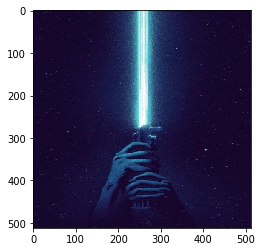

In [67]:
# Load image

img_BGR = cv2.imread('azul3.jpg')
img_BGR = cv2.resize(img_BGR, (512, 512))
n_rows, n_cols, n_channs = img_BGR.shape

img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(img_HSV)

print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Number of channels: {n_channs}")
print(img_BGR.min())
print(img_BGR.max())

print(h)
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

In [68]:
# AUX function to show magnitud and phase spectra
def show_spectrum(magn, phas):
  M, N = magn.shape
  plt.figure(figsize=(11, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(magn, cmap='gray', extent=(-N//2, N//2, -M//2, M//2))
  plt.colorbar()
  plt.title('Magnitude.')
  plt.subplot(1, 2, 2)
  plt.imshow(phas, cmap='gray', extent=(-N//2, N//2, -M//2, M//2))
  plt.colorbar()
  plt.title('Phase.')
  plt.show()

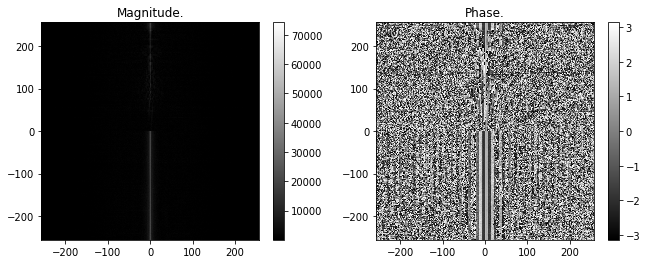

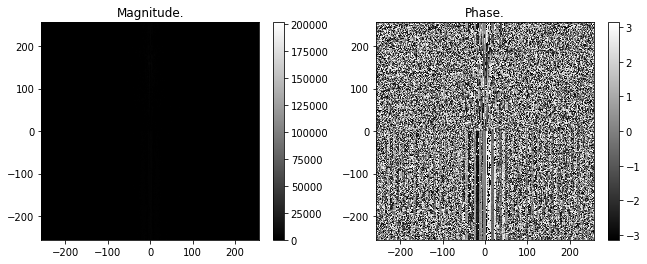

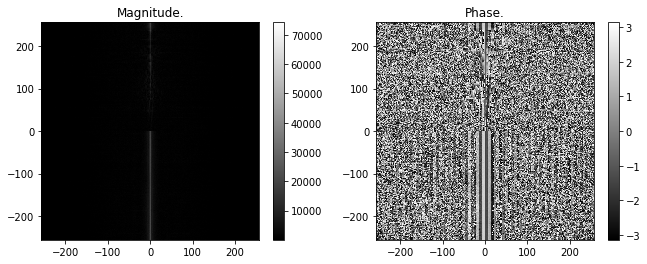

In [69]:
# Image RGB spectra
IMG = fftshift(fft2(img_HSV))
magn_IMG, phas_IMG = real_imag2magn_phas(IMG.real, IMG.imag)
show_spectrum(magn_IMG[:, :, 0], phas_IMG[:, :, 0])
show_spectrum(magn_IMG[:, :, 1], phas_IMG[:, :, 1])
show_spectrum(magn_IMG[:, :, 2], phas_IMG[:, :, 2])

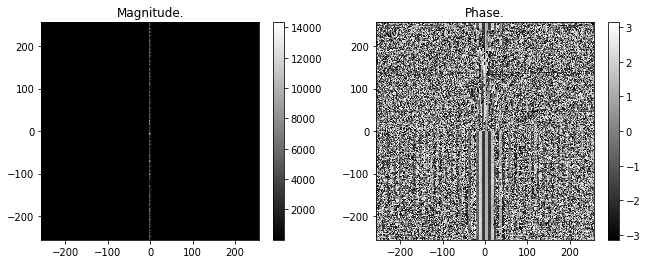

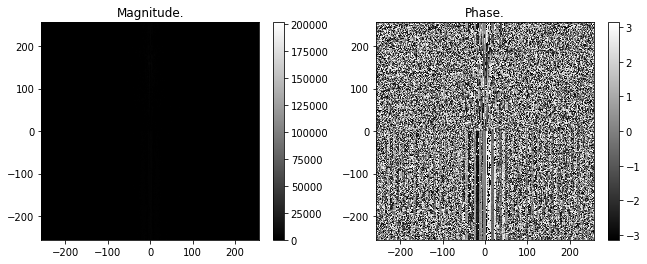

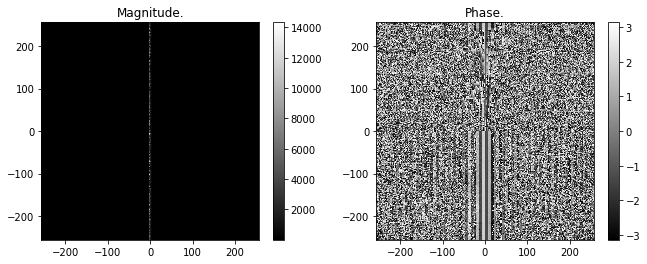

In [83]:
modul = modulate(magn_IMG, magn_chan1[20, :].T)
modul2 = modulate(modul, magn_chan1[20, :].T)
modul2[:, :, 2] = fftshift(modul2[:, :, 2])
#modul2[:, :, 1] = fftshift(modul2[:, :, 1])
modul2[:, :, 0] = fftshift(modul2[:, :, 0])

show_spectrum(modul2[:, :, 0], phas_IMG[:, :, 0])
show_spectrum(modul2[:, :, 1], phas_IMG[:, :, 1])
show_spectrum(modul2[:, :, 2], phas_IMG[:, :, 2])



(512, 512, 3)


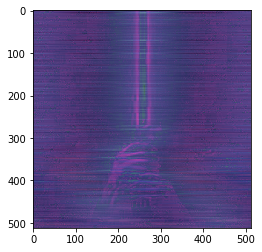

In [84]:
real, imag = magn_phas2real_imag(modul2,phas_IMG)
IMG_new = np.vectorize(complex)(real,imag)
a = ifft2(ifftshift(IMG_new)).real.astype('uint8')
img_RGBa = cv2.cvtColor(a, cv2.COLOR_HSV2RGB)
plt.imshow(img_RGBa)
print(a.shape)

# Now combine them

In [82]:
# AUX function to Modulate image with sound spectrum
# Esta es la función en la que deben modelar su diseño
def modulate(obj, modulator):
    img_out = np.zeros_like(obj)
    img_out[:, :, 0] = np.multiply(0.00003*modulator, obj[:, :, 0])
    img_out[:, :, 1] = obj[:, :, 1]
    img_out[:, :, 2] = np.multiply(0.00003*modulator, obj[:, :, 2])
    return(img_out)
    #return(phas_IMG)

In [ ]:
# Genera cada frame del nuevo video
out_images = []
for ind_interval in range(n_intervals):
    modulated = modulate(magn_IMG, magn_chan1[ind_interval, :])
    modulated2 = modulate(modulated, magn_chan2[ind_interval, :].T)
    modulated2[:, :, 2] = fftshift(modulated2[:, :, 2])
    modulated2[:, :, 0] = fftshift(modulated2[:, :, 0])
    
    real, imag = magn_phas2real_imag(modulated2,phas_IMG)
    IMG_new = np.vectorize(complex)(real,imag)
    img_mod = ifft2(ifftshift(IMG_new)).real.astype('uint8')
    #img_mod = ifft2(modulated).real.astype('uint8')
    """ # Normalización, puede o no ser requerida
    img_mod -= img_mod.min()
    if img_mod.max() != 0:
        img_mod /= img_mod.max()
    """
    img_mod_RGB = cv2.cvtColor(img_mod, cv2.COLOR_HSV2BGR)
    out_images.append(img_mod_RGB)

Once on disk, can combine the sequence of frames with audio into final video. Use from command line:
ffmpeg -i frame_seq.mp4 -i original_audio.mp3 -codec copy -shortest final_video.mp4

In [ ]:
# Save sequence of frames to disk
fps = n_intervals / L

out = VideoWriter('frame_seq.mp4', VideoWriter_fourcc(*'MP4V'), 173.15, (512, 512))
for im in out_images:
    out.write(im)
out.release()